# Petawatt Glass Amplification (OPA front end)

In [1]:
# import modules
import sys
sys.path.insert(1, '../src')
from MPA_model import *
import matplotlib.pyplot as plt

# for STFT spectrogram with time and frequency plots
# from matplotlib.ticker import NullFormatter 

## Pre Amplification Steps

In [2]:
# signal parameters
SIGNAL_RESOLUTION = int(1e5)
NPERSEG = 2**11

LAMBDA0 = 1054.45e-9 # center wavelength in meter
NU0 = lambda2nu(LAMBDA0) # center frequency in Hz
FWHM = 1e13 # in Hz
AMP = 1

PULSE_ENERGY = 0.75 # in joule
INPUT_AREA = 25e-4 # in meter square

In [3]:
signal_generator = SignalGenerator(SIGNAL_RESOLUTION//10)

In [4]:
# specify amplitude of initial pulse
theta_i = np.deg2rad(33.5) # incident angle
grating_L = 129.6e-3 # grating separation
grating_d = 0.833e-6 # grating spacing

nu_range = NU0 - speed_of_light/(grating_d*(1 + np.sin(theta_i)))
#initial_freq = np.linspace(NU0 - nu_range, NU0 + nu_range, SIGNAL_RESOLUTION)

# generate initial amplitude
PULSE_SHAPE = 'interpolate'
PAD_ZERO = False
# additional parameters depend on pulse shape
# only needed for Gaussian pulse
FWHM = 2e-9 # full width at half maximum

# only needed for pulse shape generated using interpolation
xpoints = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#ypoints = [0, 0.5, 1.5, 1.2, 1.1, 1.1, 1.2, 1.3, 0.5, 0]
ypoints = [0, 0.9, 0.85, 0.8, 0.6, 0.4, 0.3, 0.4, 0.45, 0]
kind = 'quadratic' # kind of interpolation

peak_power = signal_generator.calculate_peak_power(nu_range/10, PULSE_ENERGY, PULSE_SHAPE, FWHM = FWHM, xpoints = xpoints, ypoints = ypoints, kind = kind, pad_zero = PAD_ZERO)
initial_freq, initial_power_f = signal_generator.generate_signal(nu_range/10, peak_power, PULSE_SHAPE, FWHM = FWHM, xpoints = xpoints, ypoints = ypoints, kind = kind, pad_zero = PAD_ZERO)
initial_freq += NU0

# zero pad
initial_power_f = np.pad(initial_power_f, (int(SIGNAL_RESOLUTION*(1 - 1/10)/2), int(SIGNAL_RESOLUTION*(1 - 1/10)/2)), 'edge')
initial_freq = np.linspace(NU0 - nu_range, NU0 + nu_range, SIGNAL_RESOLUTION)
print(initial_power_f.shape)
print(initial_freq.shape)

initial_df = np.abs(initial_freq[1] - initial_freq[0]) # frequency step of initial pulse
initial_wavelength = nu2lambda(initial_freq)
initial_amp_f = np.sqrt(initial_power_f)

(100000,)
(100000,)


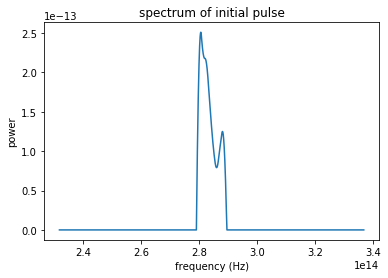

In [5]:
# plot amplitude of initial pulse
plt.plot(initial_freq, np.absolute(initial_amp_f) ** 2)
plt.title('spectrum of initial pulse')
plt.xlabel('frequency (Hz)')
plt.ylabel('power')
plt.show()

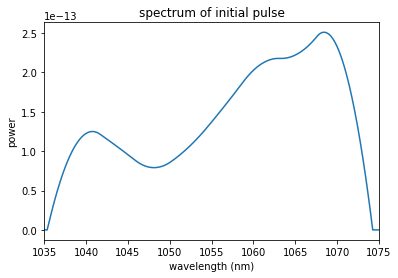

In [6]:
# plot amplitude of initial pulse
plt.plot(initial_wavelength*1e9, np.absolute(initial_amp_f) ** 2)
plt.title('spectrum of initial pulse')
plt.xlabel('wavelength (nm)')
plt.ylabel('power')
plt.xlim((1035, 1075))
plt.show()

In [7]:
# specify phase of initial pulse
theta_r0 = np.arcsin(LAMBDA0/grating_d - np.sin(theta_i)) # reflect angle of center wavelength
k_0 = 2 * np.pi/LAMBDA0 * grating_L # phase velocity shift constant
reciprocal_vg = ((1 + np.sin(theta_i) * np.sin(theta_r0))/(speed_of_light * np.cos(theta_r0)))*grating_L
dw = 2*np.pi*(initial_freq - NU0)

#initial_phase_f = 2 * np.pi / (initial_wavelength) * grating_L * np.cos(np.arcsin(initial_wavelength / grating_d - np.sin(theta_i)))
#initial_phase_f -= (k_0 + reciprocal_vg*dw) # take
initial_phase_f = np.zeros(SIGNAL_RESOLUTION)

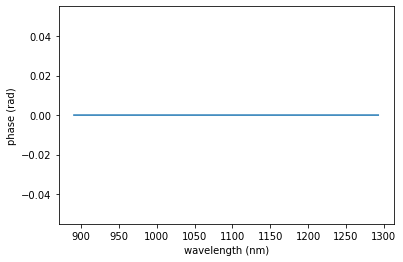

In [8]:
# plot phase of initial pulse
plt.plot(initial_wavelength * 1e9, initial_phase_f)
plt.xlabel('wavelength (nm)')
plt.ylabel('phase (rad)')
plt.show()

In [9]:
# combine amplitude and phase
initial_complex_f = polar_to_rect(initial_amp_f, initial_phase_f)

In [10]:
# transform to time domain using ifft
initial_complex_t = fftpack.ifft(initial_complex_f)
initial_time = fftpack.fftfreq(len(initial_complex_f)) * 1/initial_df

# shift the center of transformation
initial_complex_t = np.fft.fftshift(initial_complex_t)
initial_time = np.fft.fftshift(initial_time)

# rescaling to correct pulse energy
initial_amp_t, initial_phase_t = rect_to_polar(initial_complex_t)
peak_power_t = PULSE_ENERGY / np.trapz(initial_amp_t**2,  x = initial_time)
initial_amp_t = np.sqrt(peak_power_t) * initial_amp_t
initial_complex_t = polar_to_rect(initial_amp_t, initial_phase_t)

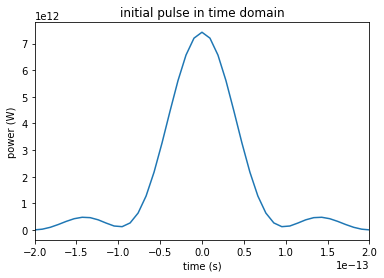

In [11]:
# convert to power
initial_power_t = np.absolute(initial_complex_t) ** 2

# plot power of initial pulse in time domain
plt.plot(initial_time, initial_power_t)
plt.title('initial pulse in time domain')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.xlim((-200e-15, 200e-15))
plt.show()

### Stretch the pulse

In [12]:
# stretcher parameters
STRETCHER_GRATING_L = 129.6e-3
STRETCHER_GRATING_D = 0.833e-6
STRETCHER_INCIDENT_ANGLE = 33.5 # in degree

# initiate stretche
stretcher = GratingPair(STRETCHER_GRATING_L, STRETCHER_GRATING_D)

# stretch the pulse
stretched_complex_t = stretcher.add_dispersion(STRETCHER_INCIDENT_ANGLE, initial_time, initial_complex_t, NU0, 10)

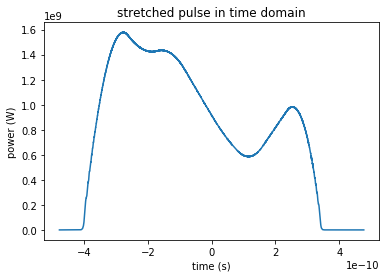

In [13]:
plt.plot(initial_time, np.absolute(stretched_complex_t)**2)
plt.title('stretched pulse in time domain')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.show()

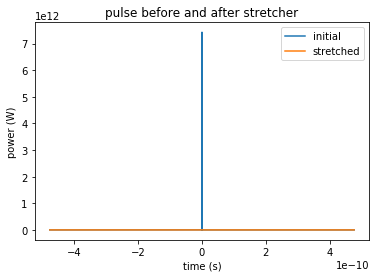

In [14]:
# plot initial pulse and stretched pulse
plt.plot(initial_time, np.absolute(initial_complex_t)**2, label = 'initial')
plt.plot(initial_time, np.absolute(stretched_complex_t)**2, label = 'stretched')
plt.title('pulse before and after stretcher')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.legend()
plt.show()

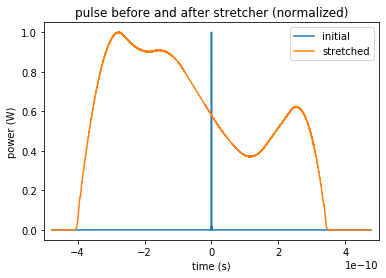

In [15]:
# plot initial pulse and stretched pulse
stretched_power_t = np.absolute(stretched_complex_t)**2
plt.plot(initial_time, initial_power_t / np.amax(initial_power_t), label = 'initial')
plt.plot(initial_time, stretched_power_t/np.amax(stretched_power_t), label = 'stretched')
plt.title('pulse before and after stretcher (normalized)')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.xlim((-5e-10, 5e-10))
plt.legend()
plt.show()

### Short Time Fourier Transform (STFT)

In [16]:
# stft parameters
freq_sampling = SIGNAL_RESOLUTION * initial_df # sampling frequency
fwindow = 'hann' # fourier window

# calculate stft
freq_pile, time_pile, stft_signal = signal.stft(stretched_complex_t, freq_sampling, window = fwindow, nperseg = NPERSEG, return_onesided = False)

# calculate associated frequency
freq_pile = np.fft.fftshift(freq_pile)
freq_pile += NU0

wavelength_pile = nu2lambda(freq_pile)
stft_df = np.abs(freq_pile[1] - freq_pile[0])
stft_dt = np.abs(time_pile[1] - time_pile[0])
stft_dfdt = stft_df * stft_dt

# rescaling the result to match the correct energy in the pulse
stft_energy = np.trapz(np.trapz(np.absolute(stft_signal)**2)) * stft_dfdt
stft_scaling = np.sqrt(PULSE_ENERGY / stft_energy)
stft_signal = stft_scaling * stft_signal

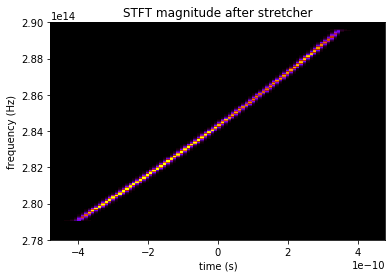

In [17]:
cmap = 'gnuplot'
vmax = 0.75
plt.pcolormesh(time_pile - np.amax(time_pile)/2, freq_pile, np.absolute(stft_signal) / np.amax(np.absolute(stft_signal)), vmax = vmax, cmap = cmap)
plt.title('STFT magnitude after stretcher')
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
plt.ylim((2.78e14, 2.9e14))
plt.show()

In [18]:
# convert time series to signal pile
input_signal_pile = pack_signal_pile(wavelength_pile, stft_signal, INPUT_AREA, stft_dfdt)

## Amplification Steps

### Multipass Amplification 1 (MPA1)

In [19]:
import pandas as pd

In [20]:
# read cross section data from ec
df = pd.read_excel('../src/glass_cross_section.xlsx')
cross_section_data = np.array(list(df['cross_section'].tolist()[1:])) * 1e-4
wavelength_data = np.array(list(df['l'].tolist()[1:])) * 1e-9

CRYSTAL1_CROSS_SECTION = np.abs(np.interp(np.abs(wavelength_pile), wavelength_data, cross_section_data))

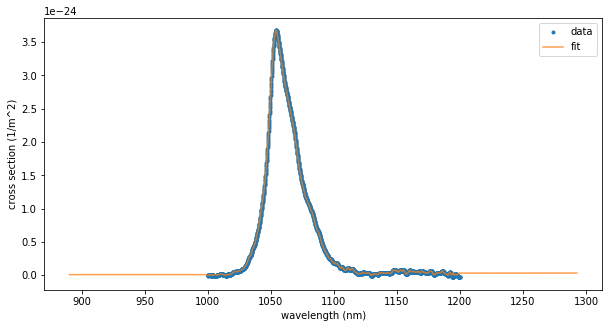

In [21]:
# plot cross section with wavelength
plt.figure(figsize = (10,5))
plt.plot(wavelength_data * 1e9, cross_section_data, '.', label = 'data')
plt.plot(wavelength_pile * 1e9, CRYSTAL1_CROSS_SECTION, '-', alpha = 0.75, label = 'fit')
plt.xlabel('wavelength (nm)')
plt.ylabel('cross section (1/m^2)')
plt.legend()
plt.show()

In [22]:
# crystal 1 parameters
CRYSTAL1_ALPHA = np.infty # attenuation in 1/m
CRYSTAL1_QD = 1 # quantum defect
CRYSTAL1_LENGTH = 15e-3 # length in meter
CRYSTAL1_N2 = 2.9e-20 # nonlinear refractive index in m^2/W

# calculate saturation fluence
CRYSTAL1_J_SAT = (Planck * np.abs(freq_pile)) / CRYSTAL1_CROSS_SECTION
CRYSTAL1_J_SAT = dict(zip(wavelength_pile, CRYSTAL1_J_SAT)) # convert to dictionary

# initiate crystal 1 object
crystal1 = Crystal(CRYSTAL1_ALPHA, CRYSTAL1_QD, CRYSTAL1_LENGTH, CRYSTAL1_N2, CRYSTAL1_J_SAT)

In [23]:
# pump energy parameters for MPA1
PUMP1_ENERGY = 140 # in joule
PUMP1_AREA = 25e-4 # in meter square
PUMP1_ENERGY_DISTRIBUTION = 'uniform'
PUMP1_FRONT_PUMP = True
PUMP1_BACK_PUMP = True

# initiate pump 1 object
pump1 = Pump(PUMP1_ENERGY, PUMP1_AREA)

In [24]:
# multipass amplifier (MPA) 1 parameters
MPA1_CRYSTAL_RESOLUTION = 10 # number of crystal splits
MPA1_NUMPASS = 4 # number of passes
MPA1_LOSS_PER_PATH = 0 # percent of energy loss per path

#initiate MPA 1 
m1 = MultiPassAmplifier(crystal1)
m1.set_crystal_res(MPA1_CRYSTAL_RESOLUTION)
m1.set_loss_per_path(MPA1_LOSS_PER_PATH)
m1.clear_passes()

In [25]:
# calculate stored energy 
store1 = m1.calculate_stored_energy_from_pump(pump1, PUMP1_ENERGY_DISTRIBUTION, front_pump = PUMP1_FRONT_PUMP, back_pump = PUMP1_BACK_PUMP)

In [26]:
# amplify the signal
after_MPA1_signal_pile = m1.calculate_multi_pass_amplification(store1, input_signal_pile, MPA1_NUMPASS)

In [27]:
# unpack signal pile back
after_MPA1_stft_signal = unpack_signal_pile(after_MPA1_signal_pile, stft_dfdt)

# rescaling for istft
after_MPA1_stft_signal = after_MPA1_stft_signal / stft_scaling

# istft
after_MPA1_time, after_MPA1_complex_t = signal.istft(after_MPA1_stft_signal, freq_sampling, window = fwindow, input_onesided = False)
after_MPA1_time = after_MPA1_time - np.amax(after_MPA1_time)/2 # shift time to be centered at zero

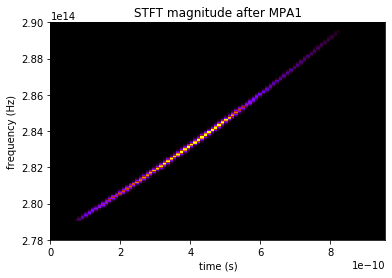

In [28]:
cmap = 'gnuplot'
vmax = 0.75
plt.pcolormesh(time_pile, freq_pile, np.absolute(after_MPA1_stft_signal) / np.amax(np.absolute(after_MPA1_stft_signal)), vmax = vmax, cmap = cmap)
plt.title('STFT magnitude after MPA1')
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
plt.ylim((2.78e14, 2.9e14))
plt.show()

/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


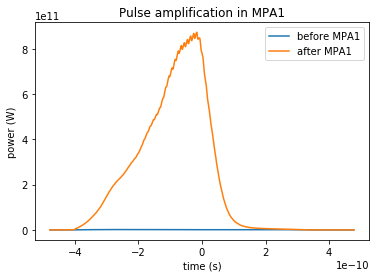

In [29]:
# convert to power
stretched_power_t = np.absolute(stretched_complex_t)**2
after_MPA1_power_t = np.absolute(after_MPA1_complex_t)**2

# plot pulse before and after amplification
plt.plot(initial_time, stretched_power_t, label = 'before MPA1')
plt.plot(after_MPA1_time, after_MPA1_power_t, label = 'after MPA1')
plt.title('Pulse amplification in MPA1')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.legend()
plt.show()

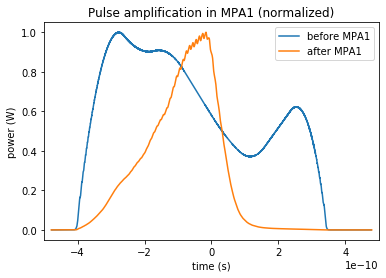

In [30]:
# plot pulse before and after amplification
plt.plot(initial_time, stretched_power_t / np.amax(stretched_power_t), label = 'before MPA1')
plt.plot(after_MPA1_time, after_MPA1_power_t / np.amax(after_MPA1_power_t), label = 'after MPA1')
plt.title('Pulse amplification in MPA1 (normalized)')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.xlim((-5e-10, 5e-10))
plt.legend()
plt.show()

## Post Amplification Steps

### Inverse Short Time Fourier Transform (ISTFT)

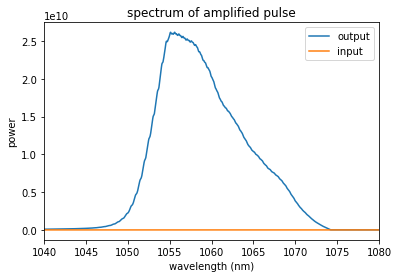

In [31]:
# find the final spectrum

# transform to frequency domain using fft
after_MPA1_complex_f = fftpack.fft(after_MPA1_complex_t)
after_MPA1_dt = np.abs(after_MPA1_time[1] - after_MPA1_time[0])
after_MPA1_freq = fftpack.fftfreq(len(after_MPA1_complex_t)) * 1/(after_MPA1_dt)

# shift the center of transformation
# after_MPA1_complex_f = np.fft.fftshift(after_MPA1_complex_f)
after_MPA1_freq = np.fft.fftshift(after_MPA1_freq)
after_MPA1_freq += NU0
after_MPA1_wavelength = nu2lambda(after_MPA1_freq)

# rescaling to correct pulse energy
after_MPA1_amp_f, after_MPA1_phase_f = rect_to_polar(after_MPA1_complex_f)
peak_power_f = PULSE_ENERGY / np.trapz(after_MPA1_amp_f**2,  x = after_MPA1_time)
after_MPA1_amp_f = np.sqrt(peak_power_f) * after_MPA1_amp_f
after_MPA1_complex_f = polar_to_rect(after_MPA1_amp_f, after_MPA1_phase_f)
after_MPA1_power_f = np.absolute(after_MPA1_complex_f)**2

plt.plot(after_MPA1_wavelength *1e9 , after_MPA1_power_f, label = 'output')
plt.plot(initial_wavelength * 1e9, initial_power_f, label = 'input')
plt.title('spectrum of amplified pulse')
plt.xlabel('wavelength (nm)')
plt.ylabel('power')
plt.legend()
plt.xlim((1040, 1080))
plt.show()

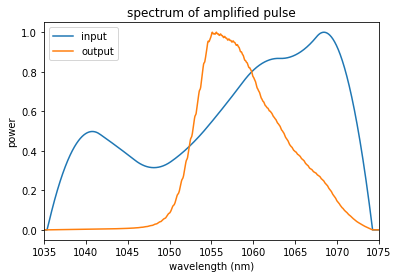

In [32]:
# transform to frequency domain using fft
after_MPA1_complex_f = fftpack.fft(after_MPA1_complex_t)
after_MPA1_dt = np.abs(after_MPA1_time[1] - after_MPA1_time[0])
after_MPA1_freq = fftpack.fftfreq(len(after_MPA1_complex_t)) * 1/(after_MPA1_dt)

# shift the center of transformation
# after_MPA1_complex_f = np.fft.fftshift(after_MPA1_complex_f)
after_MPA1_freq = np.fft.fftshift(after_MPA1_freq)
after_MPA1_freq += NU0
after_MPA1_wavelength = nu2lambda(after_MPA1_freq)

# rescaling to correct pulse energy
after_MPA1_amp_f, after_MPA1_phase_f = rect_to_polar(after_MPA1_complex_f)
peak_power_f = PULSE_ENERGY / np.trapz(after_MPA1_amp_f**2,  x = after_MPA1_freq)
after_MPA1_amp_f = np.sqrt(peak_power_f) * after_MPA1_amp_f
after_MPA1_complex_f = polar_to_rect(after_MPA1_amp_f, after_MPA1_phase_f)
after_MPA1_power_f = np.absolute(after_MPA1_complex_f)**2

plt.plot(initial_wavelength * 1e9, initial_power_f / np.amax(initial_power_f), label = 'input')
plt.plot(after_MPA1_wavelength *1e9 , after_MPA1_power_f / np.amax(after_MPA1_power_f), label = 'output')
plt.title('spectrum of amplified pulse')
plt.xlabel('wavelength (nm)')
plt.ylabel('power')
plt.legend()
plt.xlim((1035, 1075))
plt.show()

### Compress the pulse

In [33]:
# compressor parameters
COMPRESSOR_GRATING_L = 129.6e-3
COMPRESSOR_GRATING_D = 0.833e-6
COMPRESSOR_INCIDENT_ANGLE = 33.5 # in degree

# initiate compressor
compressor = GratingPair(STRETCHER_GRATING_L, STRETCHER_GRATING_D)

# compress the pulse
compressed_complex_t = compressor.add_dispersion(COMPRESSOR_INCIDENT_ANGLE, after_MPA1_time, after_MPA1_complex_t, NU0, -10)
#compressed_complex_t = compressor.compress_pulse(COMPRESSOR_INCIDENT_ANGLE, compressed_complex_t, after_MPA2_complex_t, NU0)

In [34]:
# convert to power
compressed_power_t = np.absolute(compressed_complex_t)**2

In [35]:
# calculate full width at half maximum for initial and final pulse
in_FWHM = find_FWHM(initial_time,  np.absolute(initial_complex_t)**2)
out_FWHM = find_FWHM(after_MPA1_time,  np.absolute(compressed_complex_t)**2)
print('FWHM of input pulse (s) : ' + str(in_FWHM))
print('FWHM of output pulse (s) : ' + str(out_FWHM))

FWHM of input pulse (s) : 9.53984620317208e-14
FWHM of output pulse (s) : 1.5263753925081363e-13


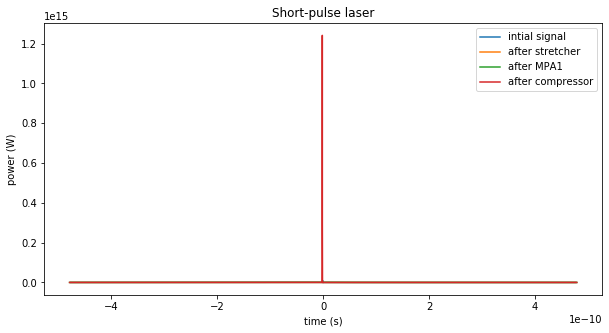

In [36]:
plt.figure(figsize = (10, 5))
plt.plot(initial_time, initial_power_t, label = 'intial signal')
plt.plot(initial_time, stretched_power_t, label = 'after stretcher')
plt.plot(after_MPA1_time, after_MPA1_power_t, label = 'after MPA1')
plt.plot(after_MPA1_time, compressed_power_t, label = 'after compressor')
plt.title('Short-pulse laser')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.legend()
plt.show()

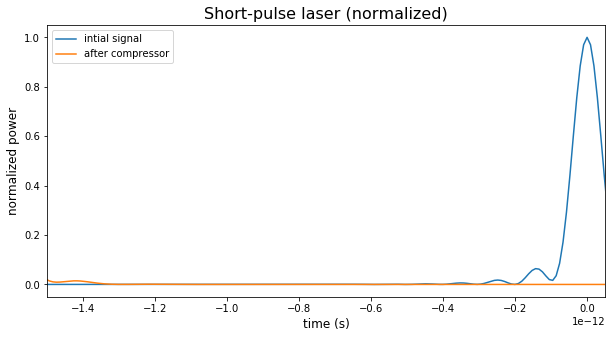

In [37]:
plt.figure(figsize = (10, 5))
plt.plot(initial_time, initial_power_t / np.amax(initial_power_t), label = 'intial signal')
#plt.plot(initial_time, stretched_power_t / np.amax(stretched_power_t), label = 'after stretcher')
#plt.plot(after_MPA1_time, after_MPA1_power_t / np.amax(after_MPA1_power_t), label = 'after MPA1')
plt.plot(after_MPA1_time, compressed_power_t / np.amax(compressed_power_t), label = 'after compressor')
plt.title('Short-pulse laser (normalized)', fontsize = 16)
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('normalized power', fontsize = 12)
plt.xlim((-1500e-15,50e-15))
plt.legend()
plt.show()

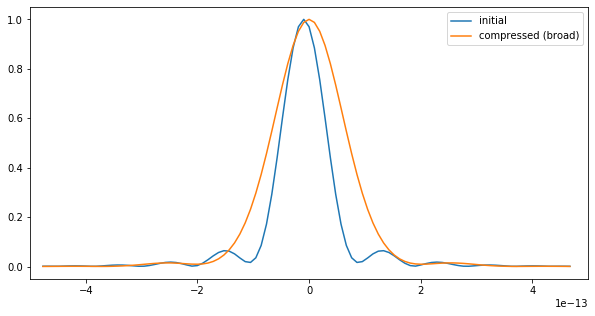

In [38]:
nmax = 100
initial_dt = np.abs(initial_time[1] -initial_time[0])
time = np.arange(-nmax*initial_dt/2, nmax*initial_dt/2, initial_dt)
plt.figure(figsize=(10,5))
plt.plot(time, get_nmax(initial_power_t, nmax)/np.amax(initial_power_t), label = 'initial')
plt.plot(time, get_nmax(compressed_power_t, nmax) / np.max(compressed_power_t), label = 'compressed (broad)')
plt.legend()
plt.xlim((-500e-15, 500e-15))
plt.show()

In [39]:
initial_df

1048234928.21875

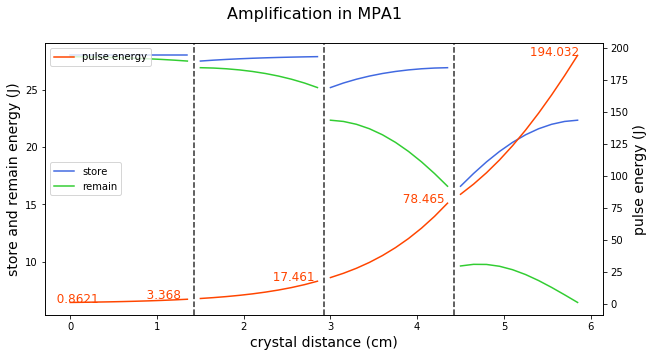

In [40]:
store_data = m1.plot_multi_pass_store_energy()
remain_data = m1.plot_multi_pass_remain_energy()

output_data = m1.plot_multi_pass_output_energy()

fig, ax1 = plt.subplots(figsize = (10,5))

plot_multi_pass_data(ax1, MPA1_NUMPASS, [store_data, remain_data], ['royalblue', 'limegreen'], ['store', 'remain'], 1e2, 1, 'center left')
ax1.set_xlabel('crystal distance (cm)', fontsize  = 14)
ax1.set_ylabel('store and remain energy (J)', fontsize = 14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

plot_multi_pass_data(ax2, MPA1_NUMPASS, [output_data], ['orangered'], ['pulse energy'], 1e2, 1, 'best')
ax2.set_ylabel('pulse energy (J)', fontsize = 14)

output_x, output_y = output_data
val = output_y[0]
ax2.text(output_x[0] - 0.25, val + 0.05, "{0:8.4f}".format(val), c = 'orangered', fontsize = 12)
plot_multi_pass_last_value(ax2, MPA1_NUMPASS, output_data, 'orangered', '{0:8.3f}', 1e2, 1, -0.6, 0, 12)

fig.suptitle('Amplification in MPA1', fontsize = 16)
#fig.savefig('../pics/short_MPA1.png')
plt.show()

In [41]:
# store data to compare with other examples
initial_spectrum_opa_plot = (initial_wavelength*1e9, np.absolute(initial_amp_f) ** 2)
initial_pulse_opa_plot = (initial_time, initial_power_t)
final_spectrum_opa_plot = (after_MPA1_wavelength *1e9 , after_MPA1_power_f)
final_spectrum_normalized_opa_plot = (after_MPA1_wavelength *1e9 , after_MPA1_power_f / np.amax(after_MPA1_power_f))
final_pulse_opa_plot = (time, get_nmax(compressed_power_t, nmax))
final_normalized_pulse_opa_plot = (time, get_nmax(compressed_power_t, nmax) / np.max(compressed_power_t))
cross_section = (wavelength_pile*1e9, CRYSTAL1_CROSS_SECTION)
%store initial_spectrum_opa_plot
%store initial_pulse_opa_plot
%store final_spectrum_opa_plot
%store final_spectrum_normalized_opa_plot
%store final_pulse_opa_plot
%store final_normalized_pulse_opa_plot
%store cross_section

Stored 'initial_spectrum_opa_plot' (tuple)
Stored 'initial_pulse_opa_plot' (tuple)
Stored 'final_spectrum_opa_plot' (tuple)
Stored 'final_spectrum_normalized_opa_plot' (tuple)
Stored 'final_pulse_opa_plot' (tuple)
Stored 'final_normalized_pulse_opa_plot' (tuple)
Stored 'cross_section' (tuple)


In [42]:
# get output signal pile from MPA
pl_signal_pile = m1.get_single_pass_output(0)

# unpack signal pile back
pl_stft_signal = unpack_signal_pile(pl_signal_pile, stft_dfdt)

# rescaling for istft
pl_stft_signal = pl_stft_signal / stft_scaling

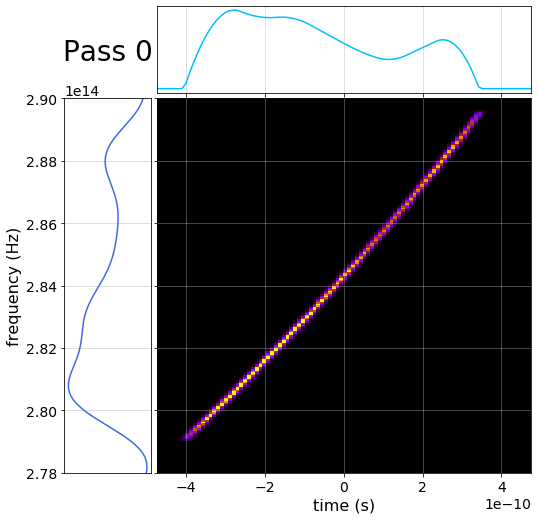

In [44]:
# plot STFT spectrogram with time and frequency plots

nullfmt = NullFormatter() # no label

# definitions for the axes
left, width = 0.1 + 0.2, 0.65
bottom, height = 0.1, 0.65

rect_center = [left, bottom, width, height]
rect_plotx = [left, bottom + width + 0.01, width, 0.15]
rect_ploty = [left - 0.01 - 0.15, bottom, 0.15, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

ax_center = plt.axes(rect_center)
ax_plotx = plt.axes(rect_plotx)
ax_ploty = plt.axes(rect_ploty)

# remove labels
ax_plotx.xaxis.set_major_formatter(nullfmt)
ax_plotx.yaxis.set_major_formatter(nullfmt)
ax_ploty.xaxis.set_major_formatter(nullfmt)
ax_center.yaxis.set_major_formatter(nullfmt)

# remove ticks
ax_plotx.set_yticks([])
ax_ploty.set_xticks([])

# set grid on time and frequency plots
ax_plotx.grid(alpha = 0.5)
ax_ploty.grid(alpha = 0.5)

# the center plot
cmap = 'gnuplot'
vmax = 0.75
ax_center.pcolormesh(time_pile - np.amax(time_pile)/2, freq_pile, np.absolute(pl_stft_signal) / np.amax(np.absolute(pl_stft_signal)), vmax = vmax, cmap = cmap)
# set grid
ax_center.grid(True, axis = 'both', alpha = 0.5)

# plot data on time and frequency plots
ax_plotx.plot(time_pile - np.amax(time_pile)/2, np.sum(np.absolute(pl_stft_signal)**2, axis = 0), color = 'deepskyblue')
clean_y = clean_data_low_pass(freq_pile, np.sum(np.absolute(pl_stft_signal)**2, axis = 1))
ax_ploty.plot(-clean_y, freq_pile, color = 'royalblue')

# set x and y value range
ax_center.set_xlim((-4.75e-10, 4.75e-10))
ax_plotx.set_xlim((-4.75e-10, 4.75e-10))
ax_center.set_ylim((2.78e14, 2.9e14))
ax_ploty.set_ylim((2.78e14, 2.9e14))

# set axis labels and title
ax_center.set_xlabel('time (s)', fontsize = 14)
ax_center.set_ylabel('frequency (Hz)', fontsize = 14)
plt.title('Pass 0', y = height + 0.4375, fontsize = 20)

# save figure
# plt.savefig('../pics/pw_opa_p0.png', quality = 95, dpi = 600, bbox_inches='tight')
plt.show()